# Customer Segmentation for Banking Services 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA  

In [2]:
# Define the CSV file path
csv_file_path = 'bank-full.csv'  # Update this with the correct path

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path, sep=';')

# Step 1: Initial Exploration of the Dataset
print("\n--- Initial Exploration of the Dataset ---")
print("\nFirst 5 rows of the dataset:")
print(df.head())  # Display the first 5 rows to get an overview of the data

# Display dataset info (column names, non-null counts, and data types)
print("\nDataset Information:")
print(df.info())

# Summary statistics for numerical features
print("\nSummary Statistics for Numerical Features:")
print(df.describe())

# Summary for categorical features
print("\nSummary for Categorical Features:")
print(df.describe(include='object'))


--- Initial Exploration of the Dataset ---

First 5 rows of the dataset:
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  

Dataset Information:
<class 'pandas.


--- Missing Values Analysis ---

Columns with Missing Values:
Series([], dtype: int64)


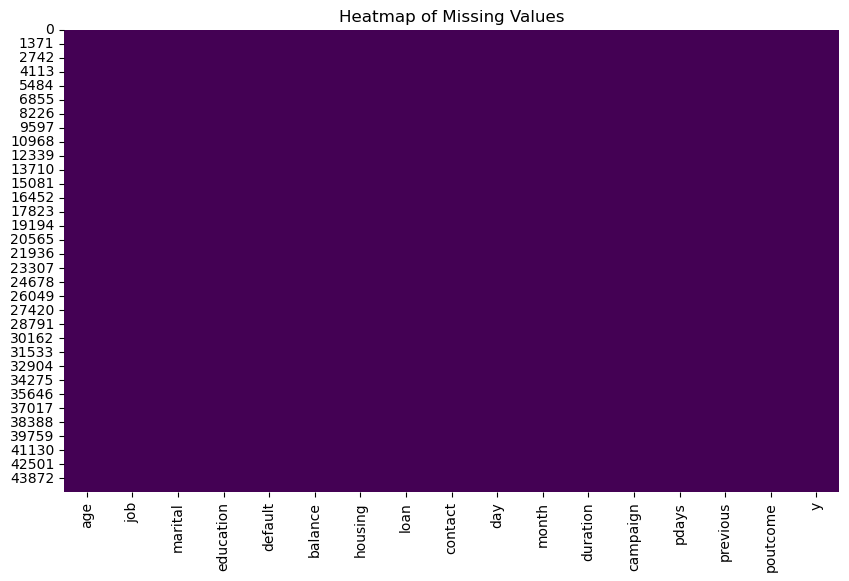


Missing values after handling:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [3]:
# Step 2: Identify and Handle Missing Values
print("\n--- Missing Values Analysis ---")
missing_values = df.isnull().sum()
missing_columns = missing_values[missing_values > 0]
print("\nColumns with Missing Values:")
print(missing_columns)

# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()

# Fill missing values
for col in missing_columns.index:
    if df[col].dtype in ['float64', 'int64']:
        df[col].fillna(df[col].median(), inplace=True)  # Impute numerical columns with median
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)  # Impute categorical columns with mode

print("\nMissing values after handling:")
print(df.isnull().sum())  # Check if all missing values are handled


In [4]:
# Step 3: Duplicate Data Check
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows found: {duplicates}")
if duplicates > 0:
    df.drop_duplicates(inplace=True)
    print(f"{duplicates} duplicates have been removed.")

# Step 4: Outlier Detection and Handling
print("\n--- Outlier Detection ---")
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))]
    num_outliers = len(outliers)
    print(f"Number of potential outliers in '{col}': {num_outliers}")

    # Capping outliers
    df[col] = np.where(df[col] < (Q1 - 1.5 * IQR), (Q1 - 1.5 * IQR), df[col])
    df[col] = np.where(df[col] > (Q3 + 1.5 * IQR), (Q3 + 1.5 * IQR), df[col])



Number of duplicate rows found: 0

--- Outlier Detection ---
Number of potential outliers in 'age': 487
Number of potential outliers in 'balance': 4729
Number of potential outliers in 'day': 0
Number of potential outliers in 'duration': 3235
Number of potential outliers in 'campaign': 3064
Number of potential outliers in 'pdays': 8257
Number of potential outliers in 'previous': 8257



--- Initial Feature Analysis ---


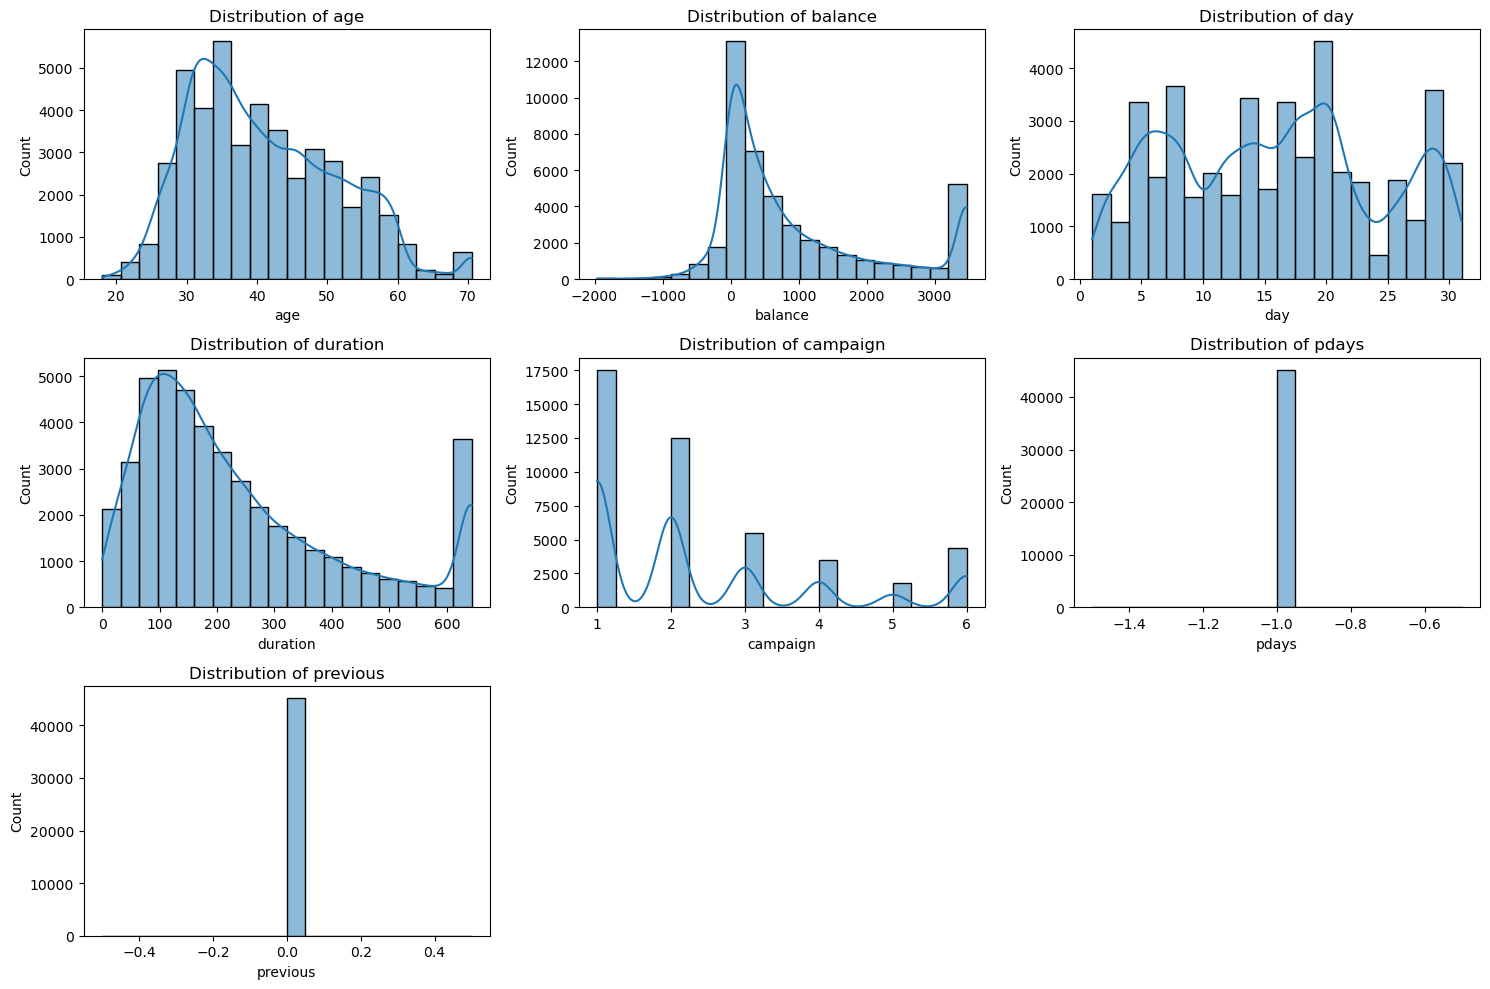

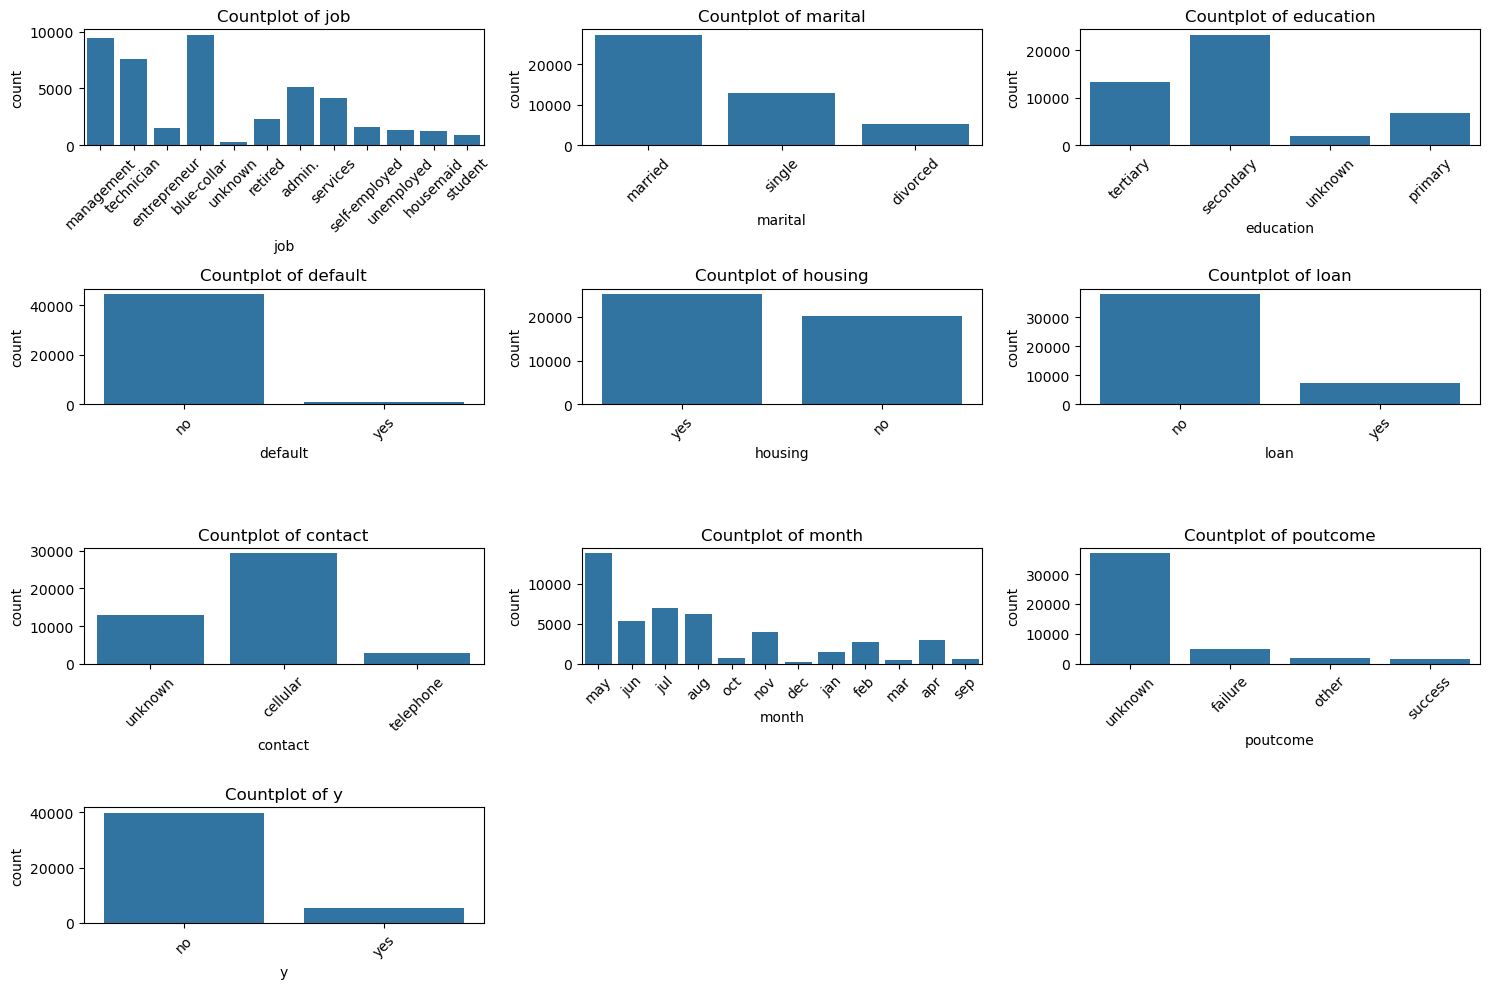

In [5]:
# Step 5: Initial Feature Analysis
print("\n--- Initial Feature Analysis ---")
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns):
    plt.subplot((len(numerical_columns) + 2) // 3, 3, i + 1)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Bar plots for categorical features
categorical_columns = df.select_dtypes(include='object').columns
if len(categorical_columns) > 0:
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(categorical_columns):
        plt.subplot((len(categorical_columns) + 2) // 3, 3, i + 1)
        sns.countplot(x=col, data=df)
        plt.title(f'Countplot of {col}')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No categorical columns found in the dataset.")



--- Correlation Analysis ---


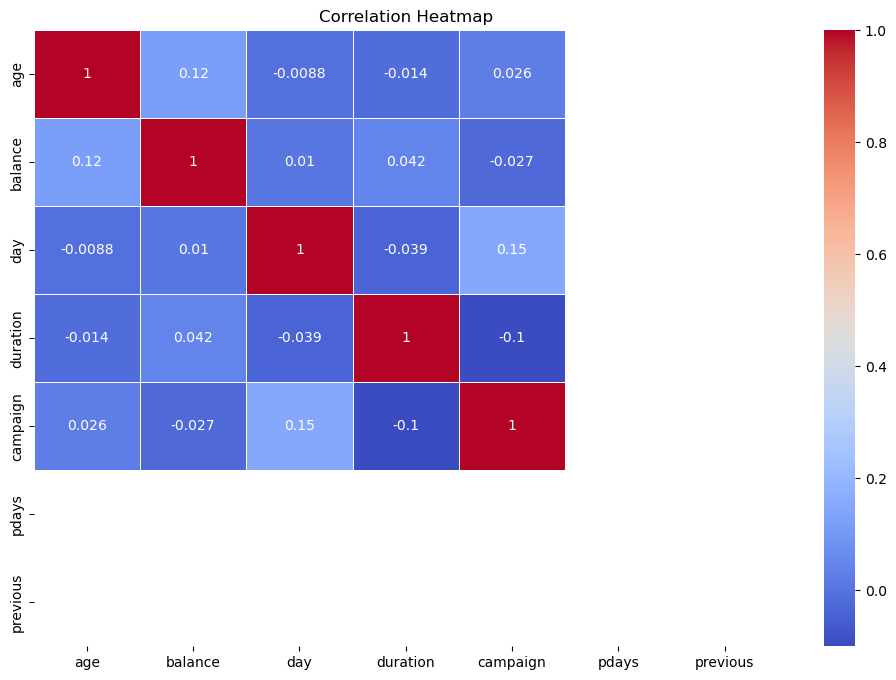

In [6]:
# Step 6: Correlation Analysis
print("\n--- Correlation Analysis ---")
corr_matrix = df[numerical_columns].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [7]:
# Step 7: Feature Engineering
print("\n--- Feature Engineering ---")
# Encoding Categorical Features
onehot_encoder = OneHotEncoder(drop='first', sparse_output=False)
column_transformer = ColumnTransformer(
    transformers=[('cat', onehot_encoder, categorical_columns)],
    remainder='passthrough'  # Keep the remaining columns as they are
)
encoded_data = column_transformer.fit_transform(df)

# Creating DataFrame from the encoded data
encoded_column_names = column_transformer.get_feature_names_out()
encoded_df = pd.DataFrame(encoded_data, columns=encoded_column_names)

# Scaling Numerical Features
print("\n--- Scaling Numerical Features ---")
numerical_features = encoded_df.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
encoded_df[numerical_features] = scaler.fit_transform(encoded_df[numerical_features])

# Final Data Preparation for Clustering
print("\nFinal Processed Dataset Information:")
print(encoded_df.info())


--- Feature Engineering ---

--- Scaling Numerical Features ---

Final Processed Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   cat__job_blue-collar      45211 non-null  float64
 1   cat__job_entrepreneur     45211 non-null  float64
 2   cat__job_housemaid        45211 non-null  float64
 3   cat__job_management       45211 non-null  float64
 4   cat__job_retired          45211 non-null  float64
 5   cat__job_self-employed    45211 non-null  float64
 6   cat__job_services         45211 non-null  float64
 7   cat__job_student          45211 non-null  float64
 8   cat__job_technician       45211 non-null  float64
 9   cat__job_unemployed       45211 non-null  float64
 10  cat__job_unknown          45211 non-null  float64
 11  cat__marital_married      45211 non-null  float64
 12  cat__marital_


--- K-Means Clustering ---


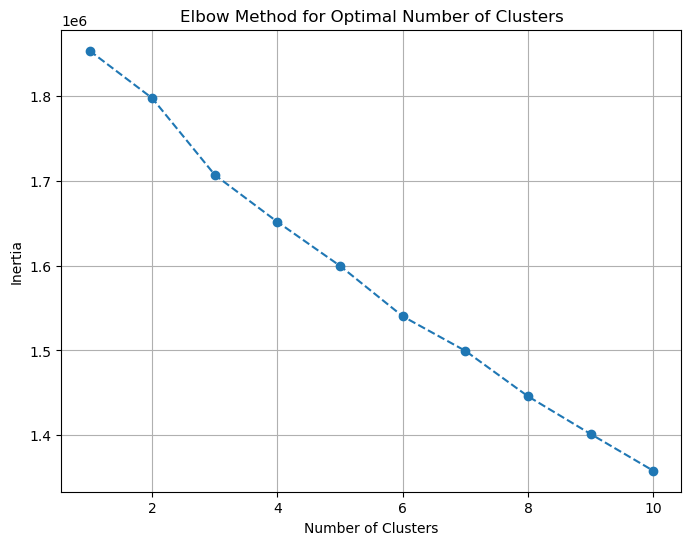


Silhouette Score for k=4: 0.0765


C:\Users\milto\AppData\Local\Temp\ipykernel_22612\781151596.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=encoded_df, palette='viridis')


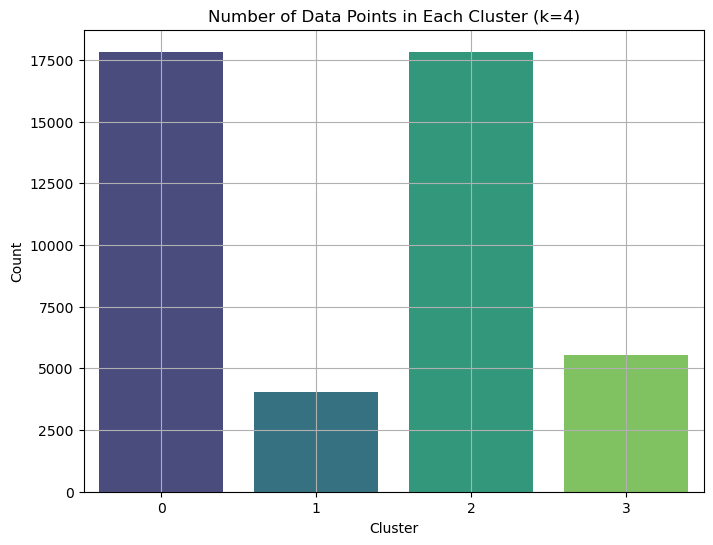


--- Cluster Centers ---
   cat__job_blue-collar  cat__job_entrepreneur  cat__job_housemaid  \
0             -0.170825               0.025993            0.057019   
1             -0.080869              -0.021011           -0.057541   
2              0.282648              -0.000693           -0.038418   
3             -0.301432              -0.065957           -0.017568   

   cat__job_management  cat__job_retired  cat__job_self-employed  \
0             0.131360         -0.006802                0.031302   
1            -0.001845         -0.004257                0.015589   
2            -0.172503         -0.095572               -0.034372   
3             0.134281          0.332555               -0.001392   

   cat__job_services  cat__job_student  cat__job_technician  \
0          -0.043867         -0.069491             0.098535   
1          -0.008570          0.107419            -0.017419   
2           0.087100         -0.043212            -0.086116   
3          -0.133046          0

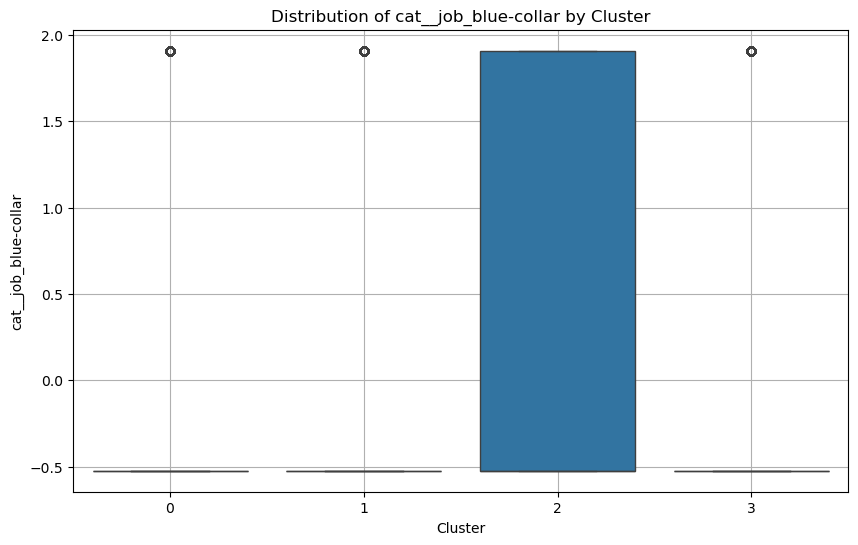

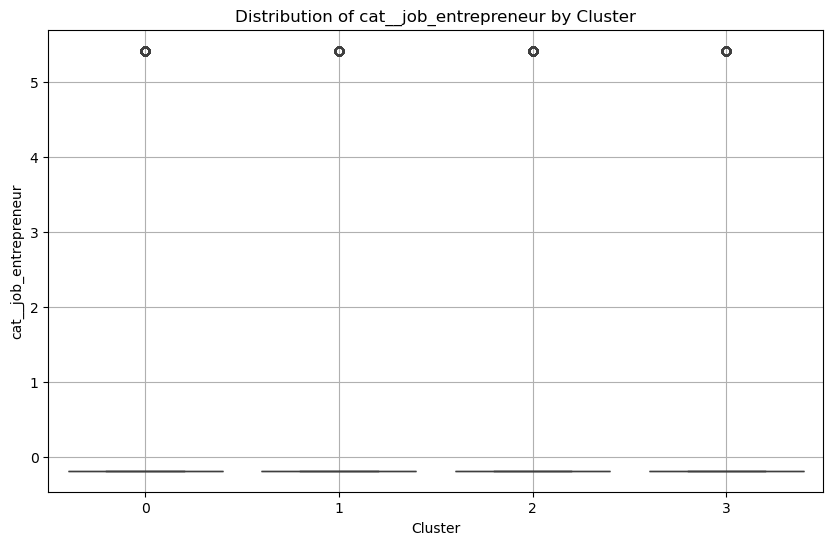

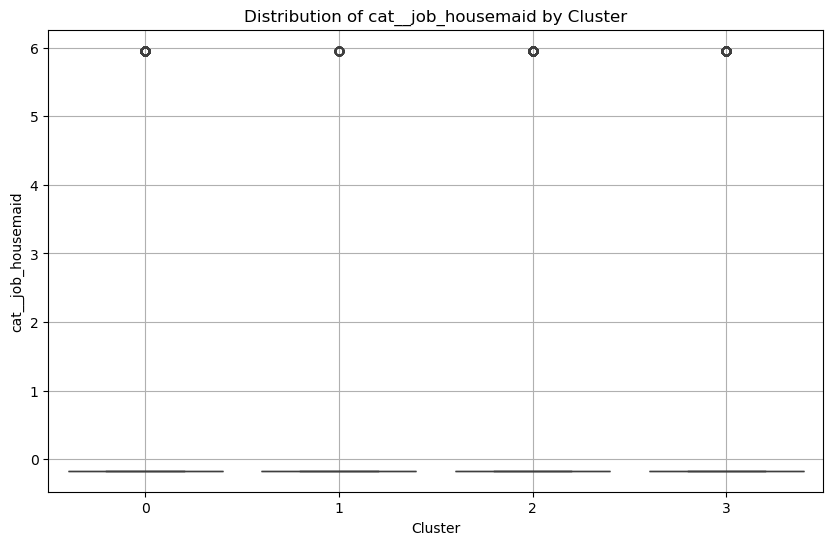

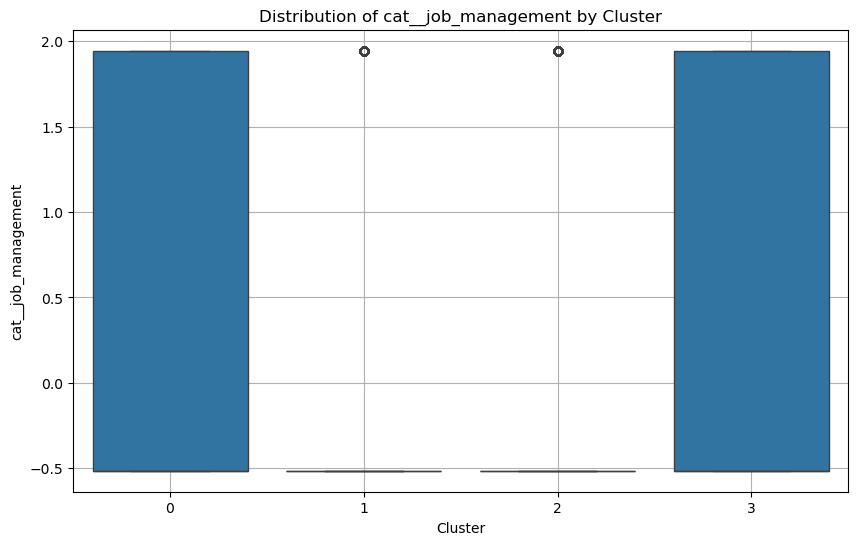

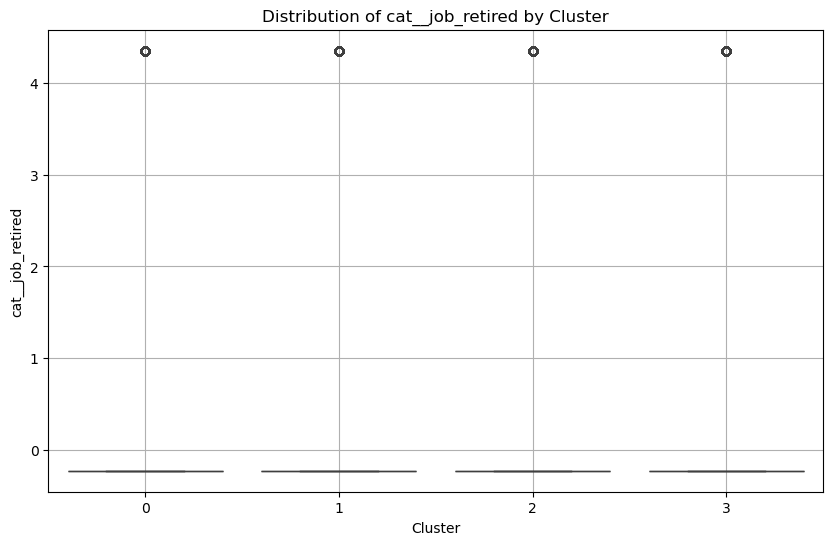

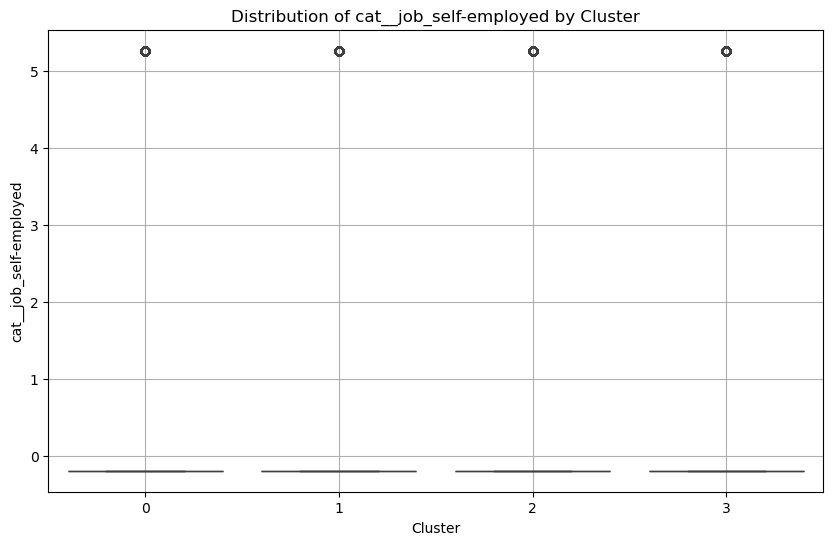

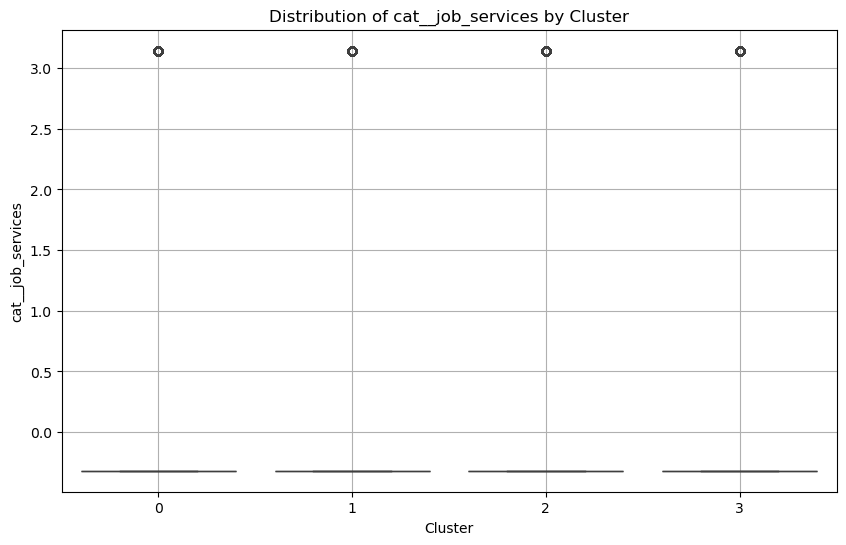

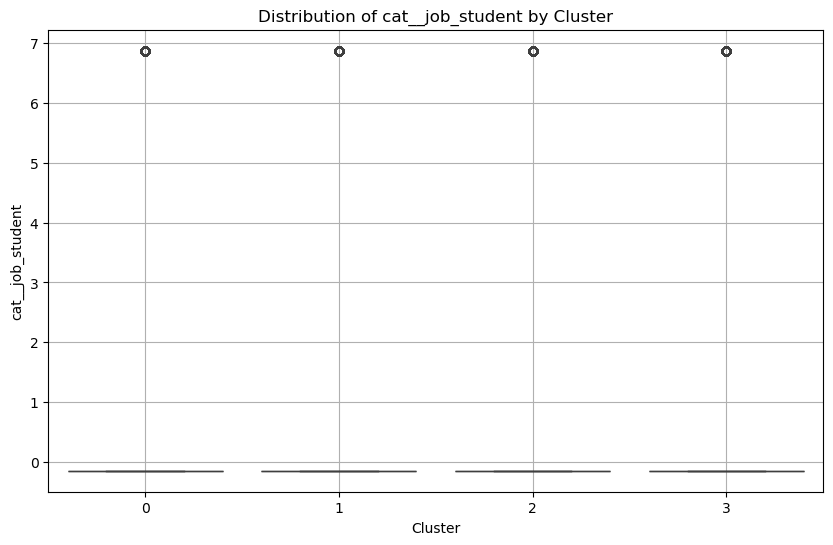

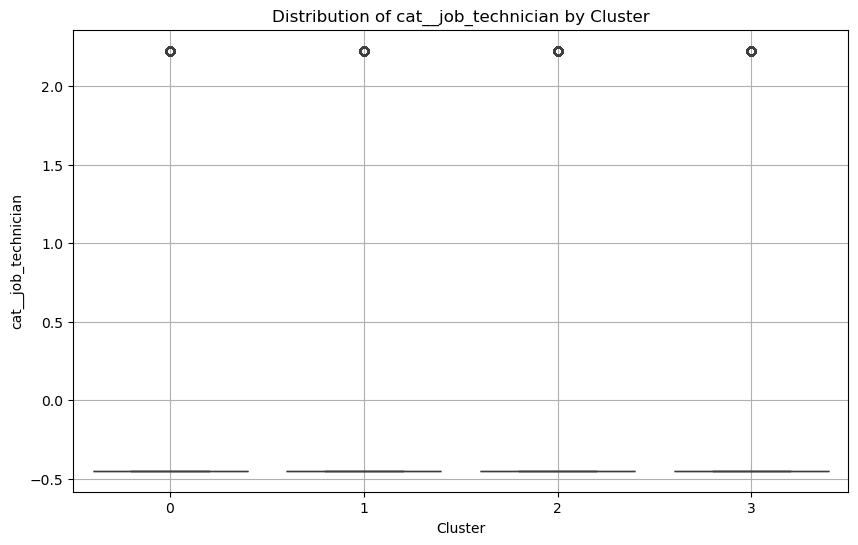

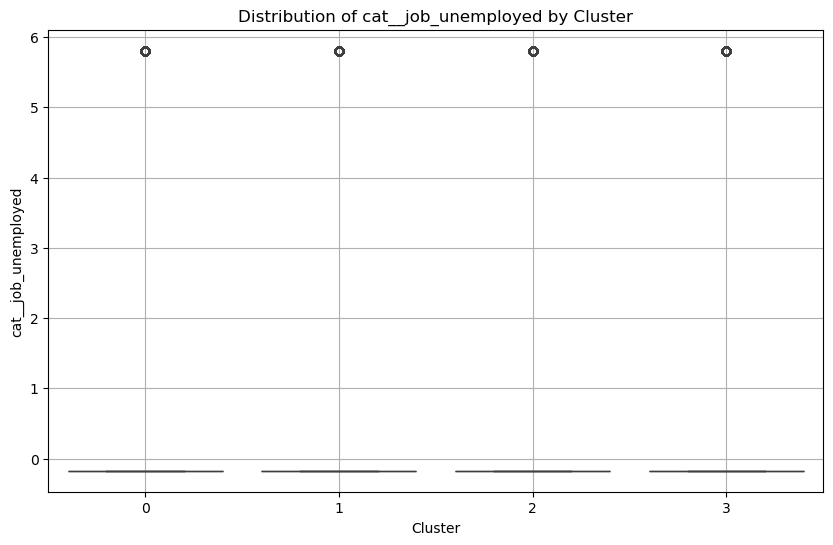

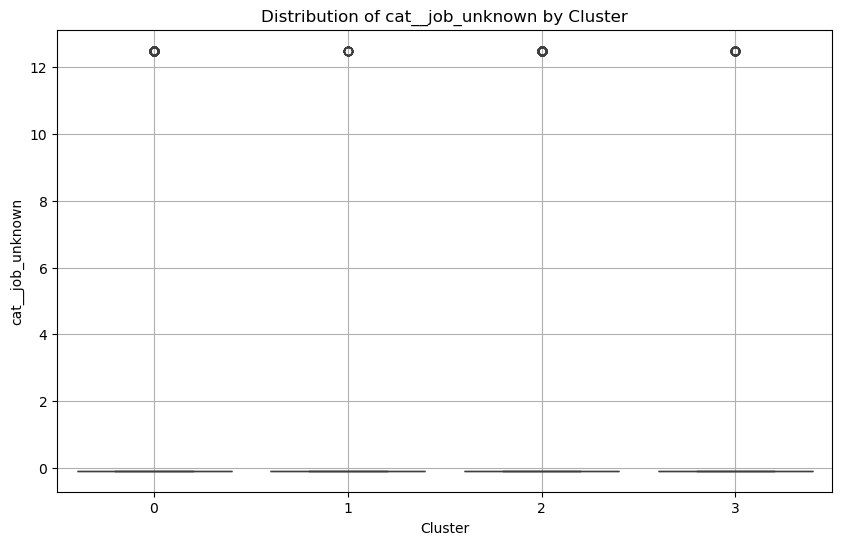

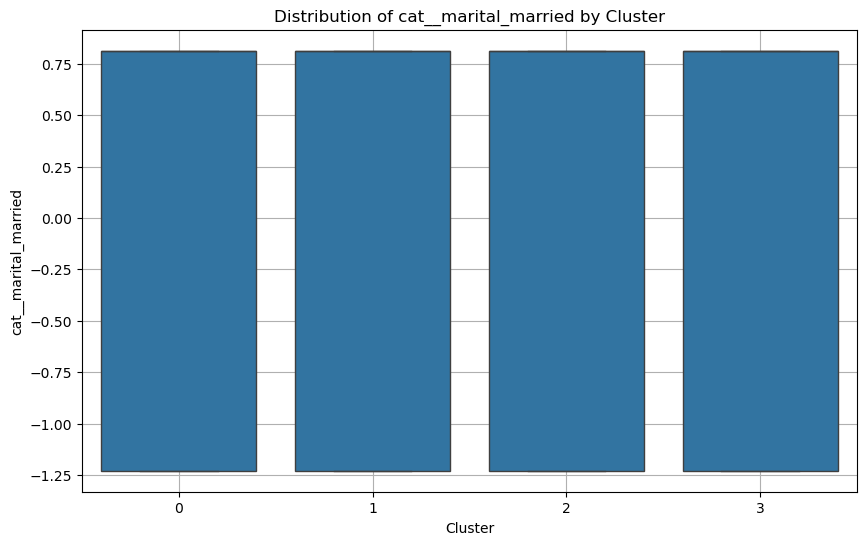

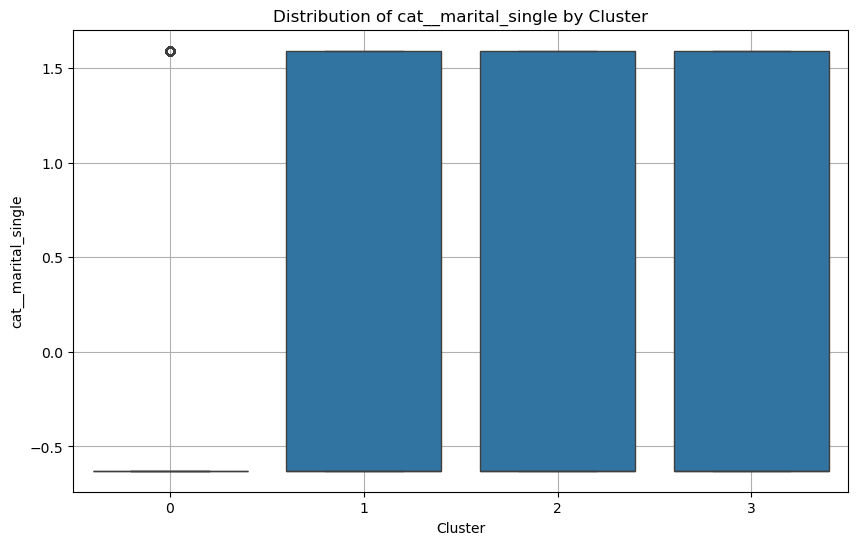

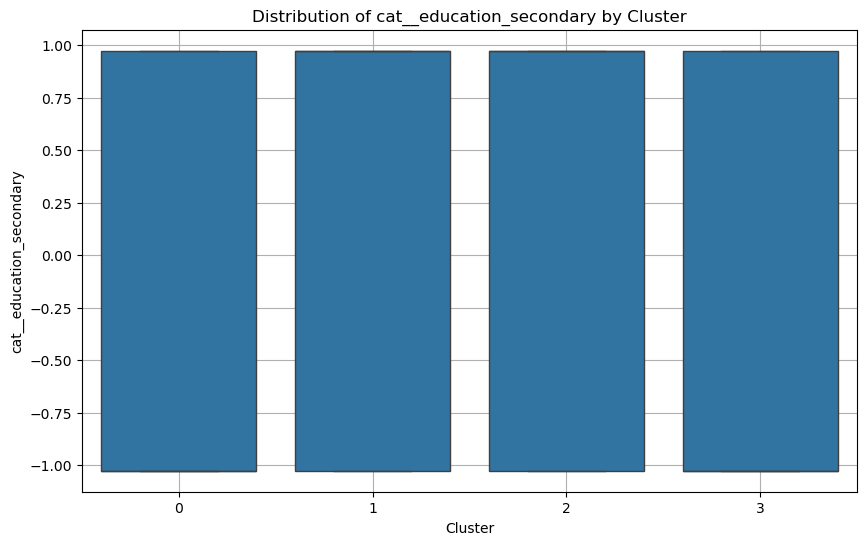

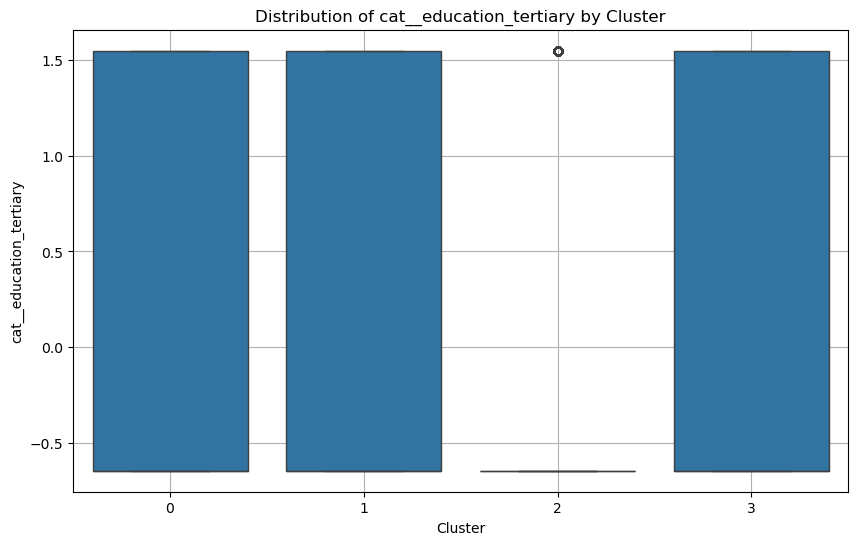

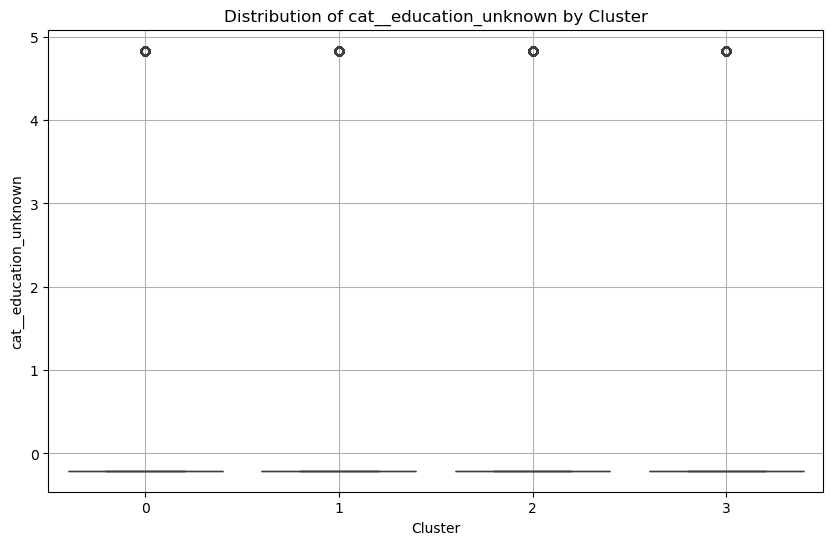

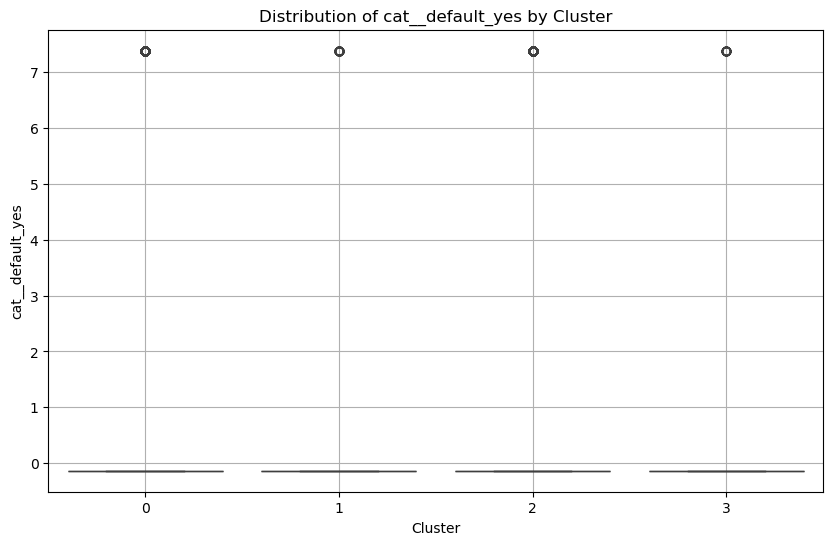

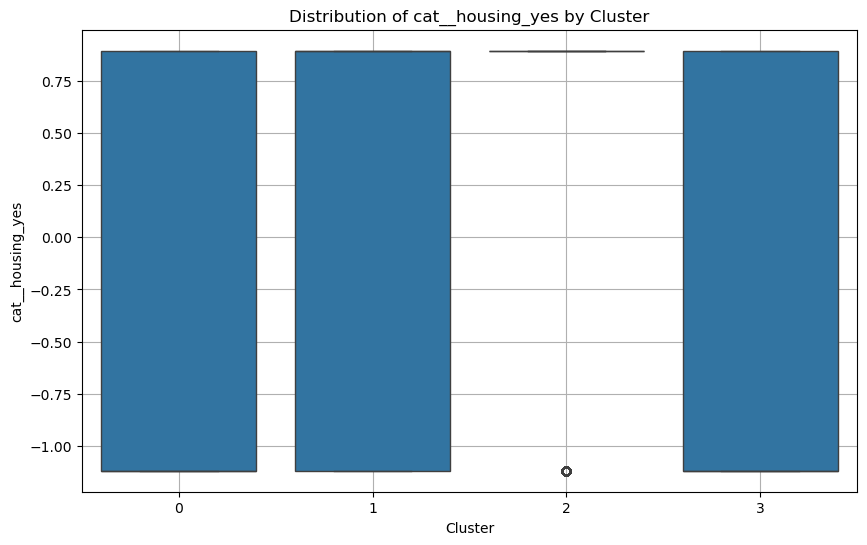

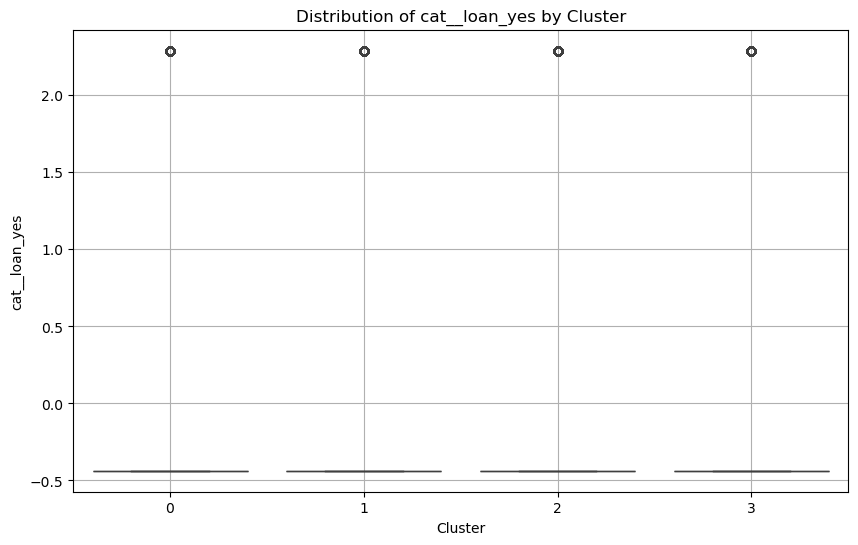

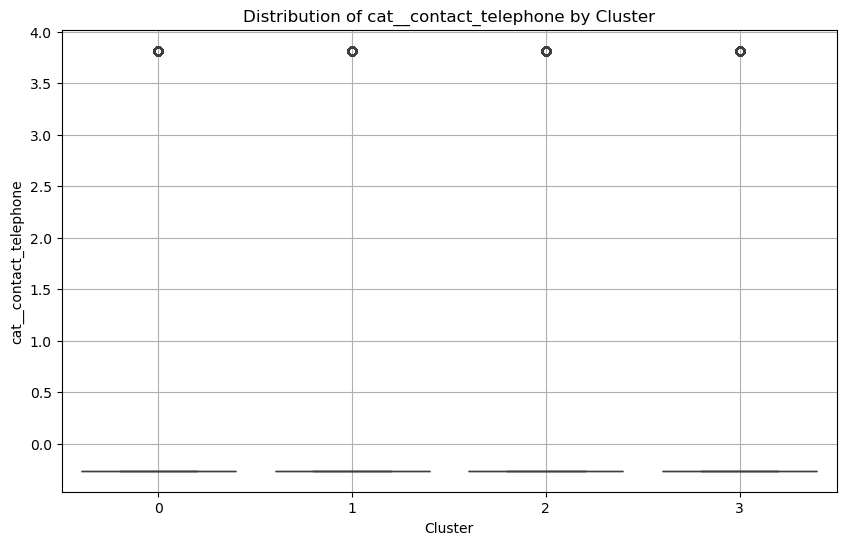

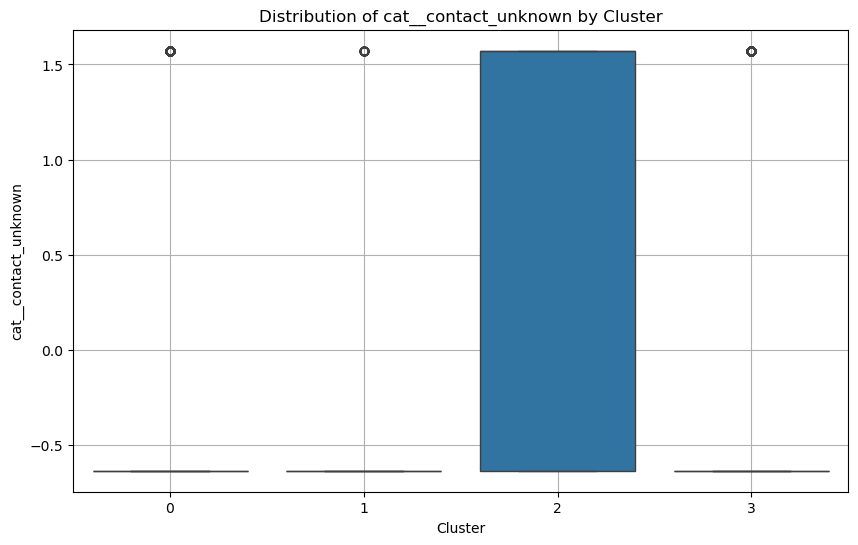

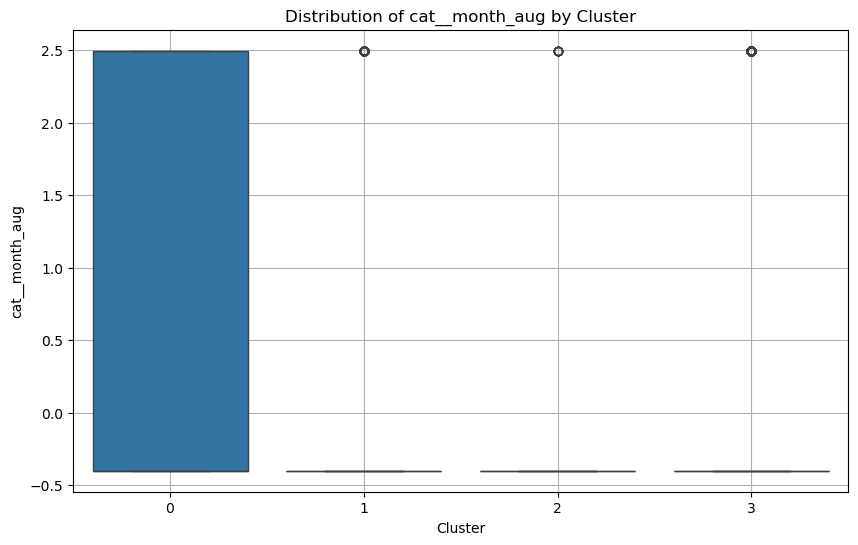

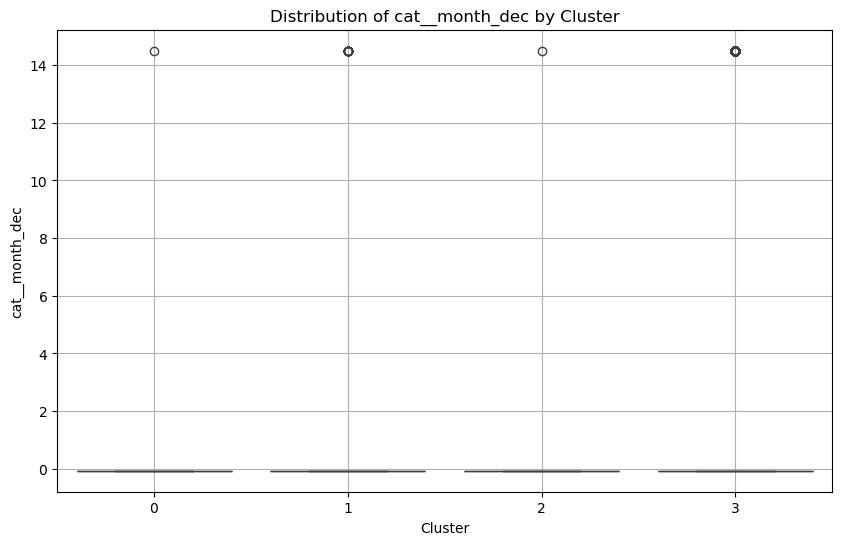

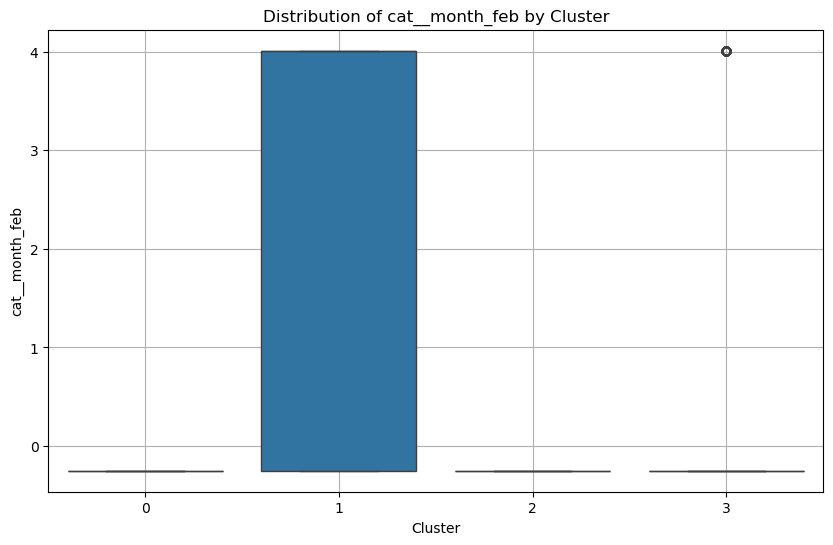

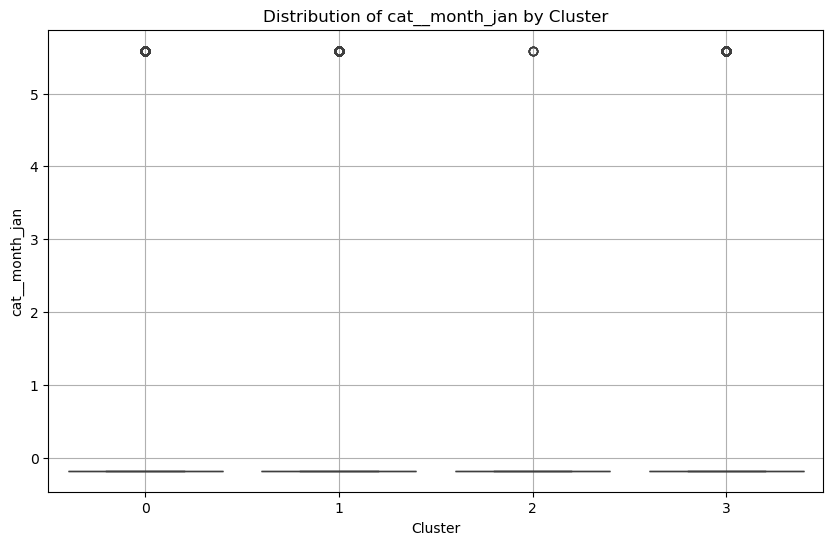

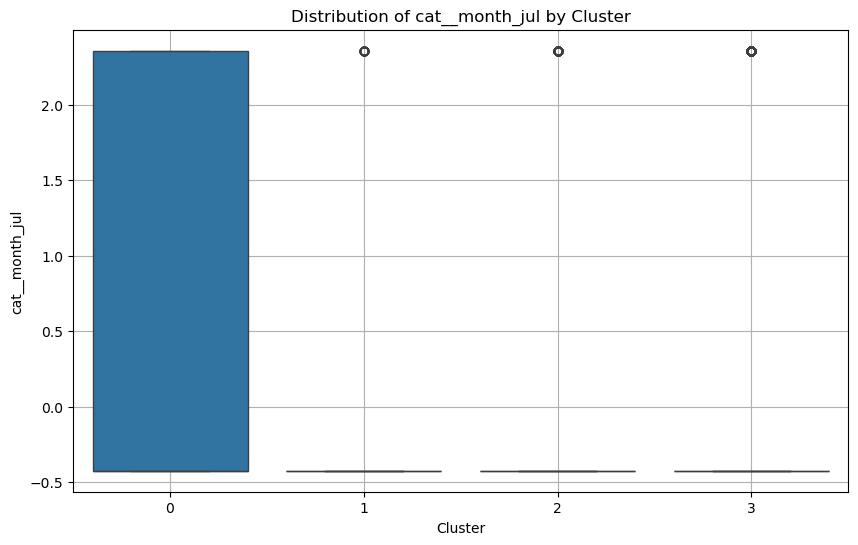

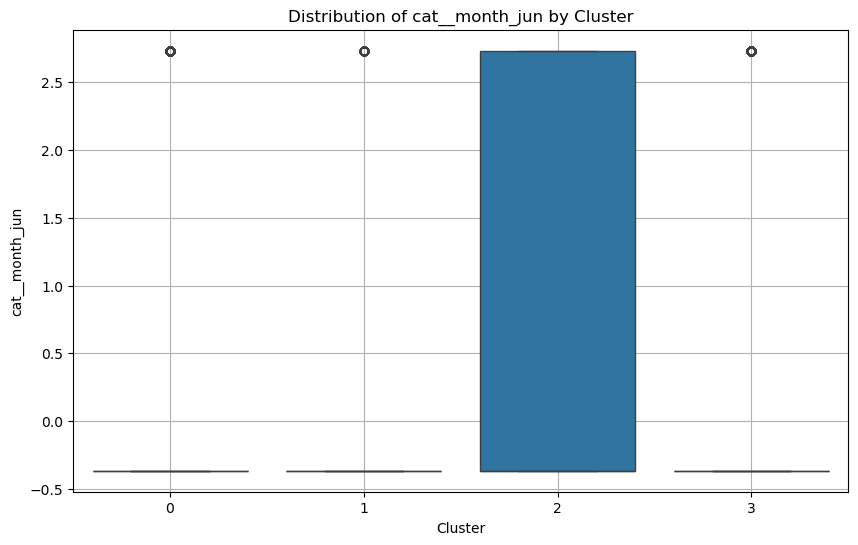

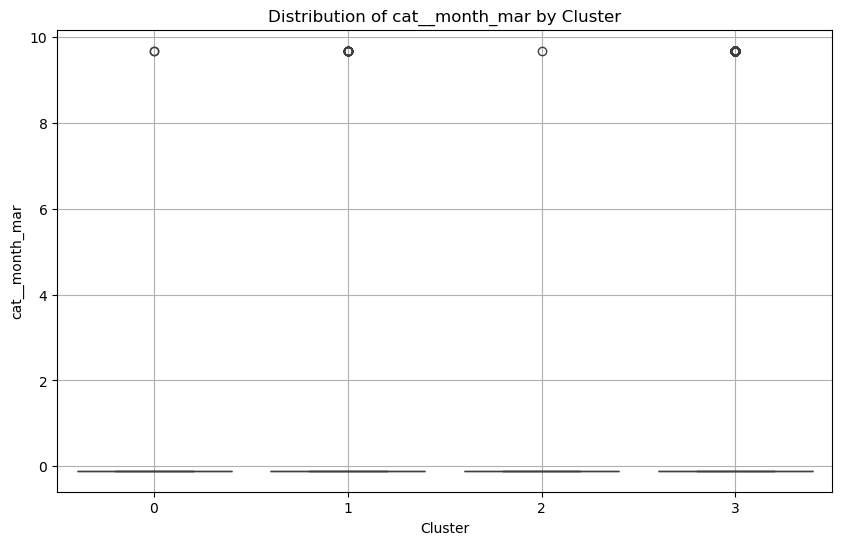

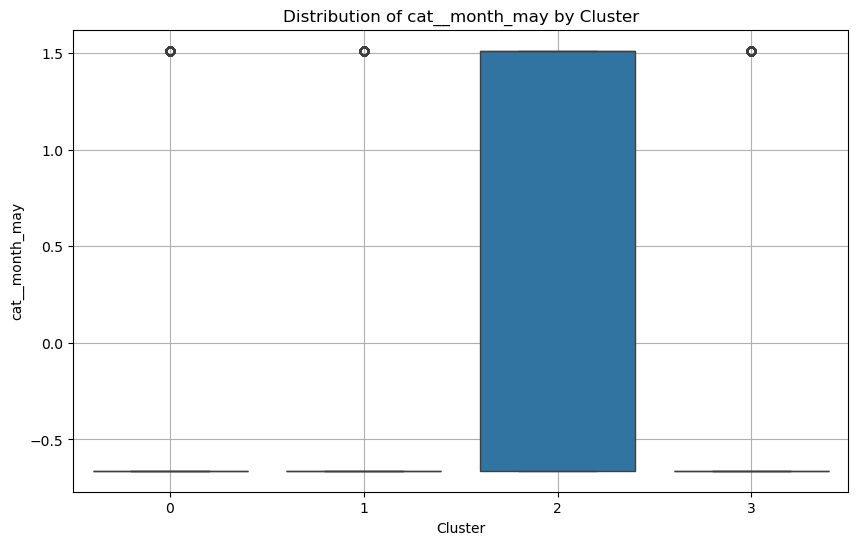

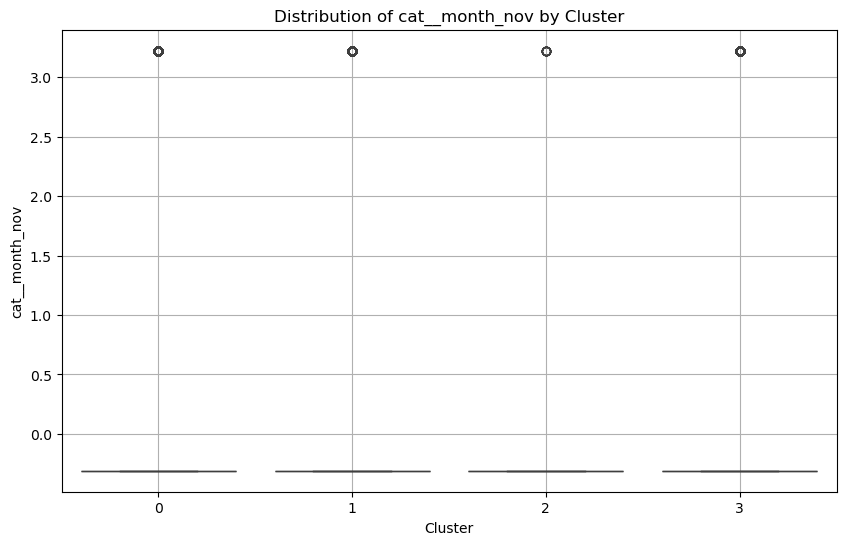

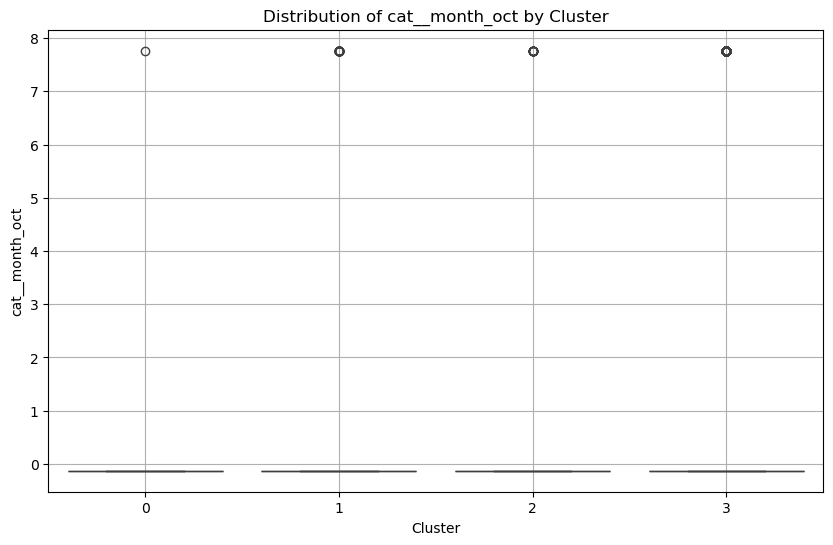

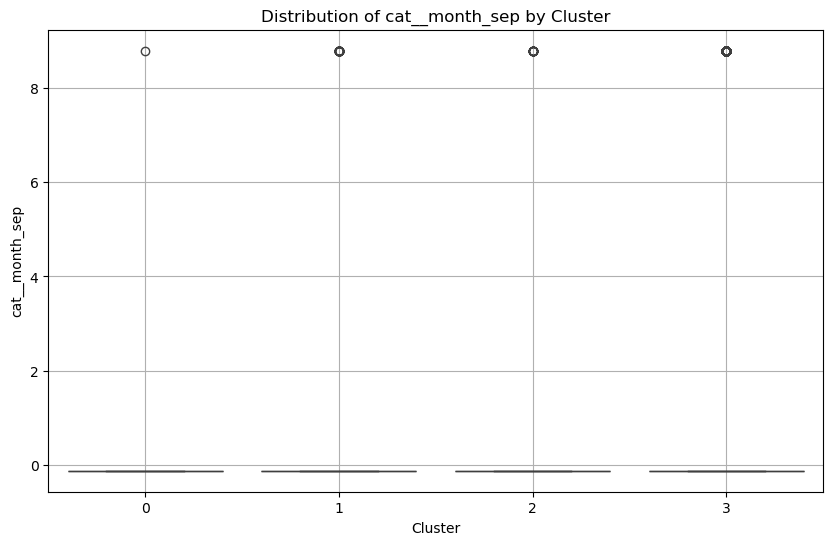

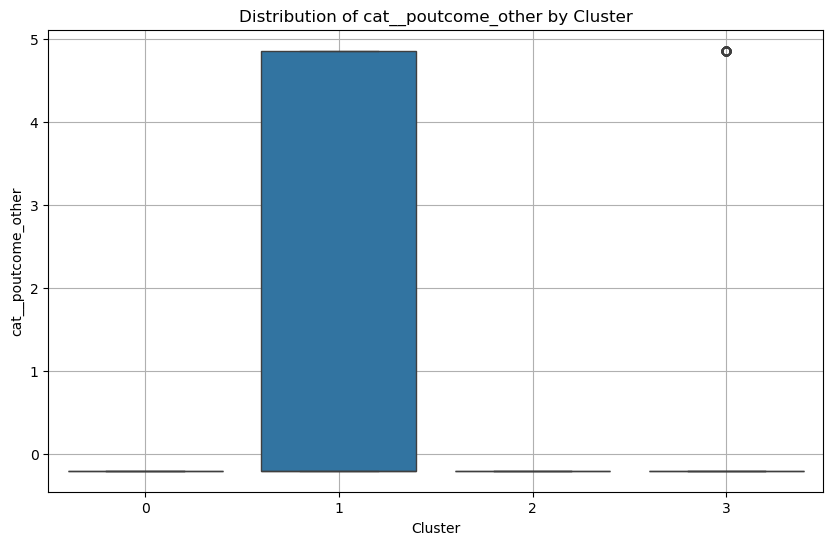

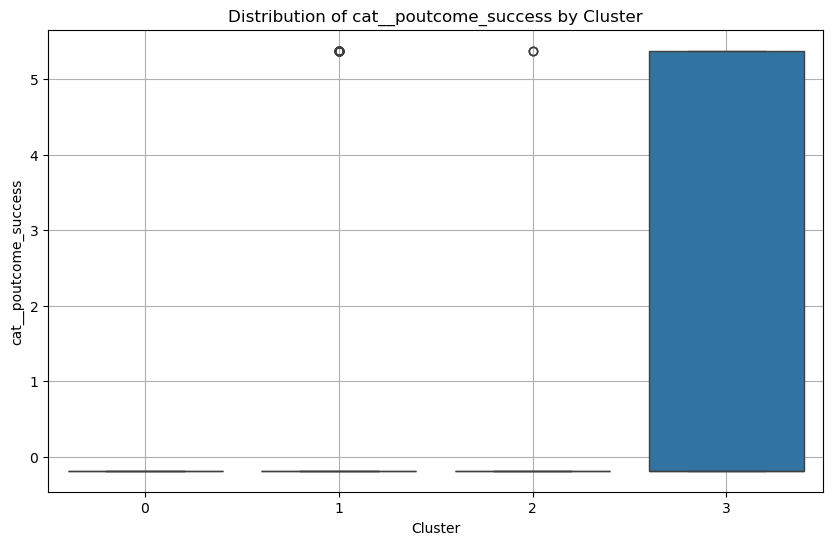

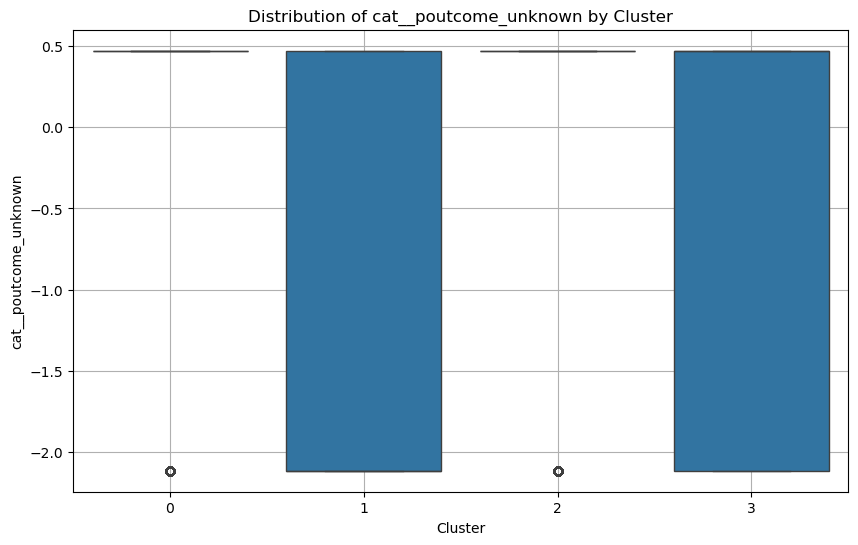

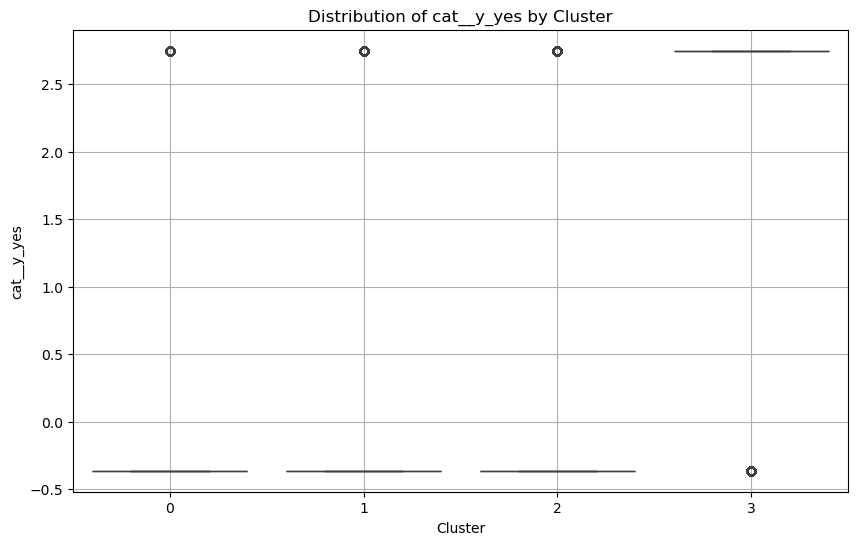

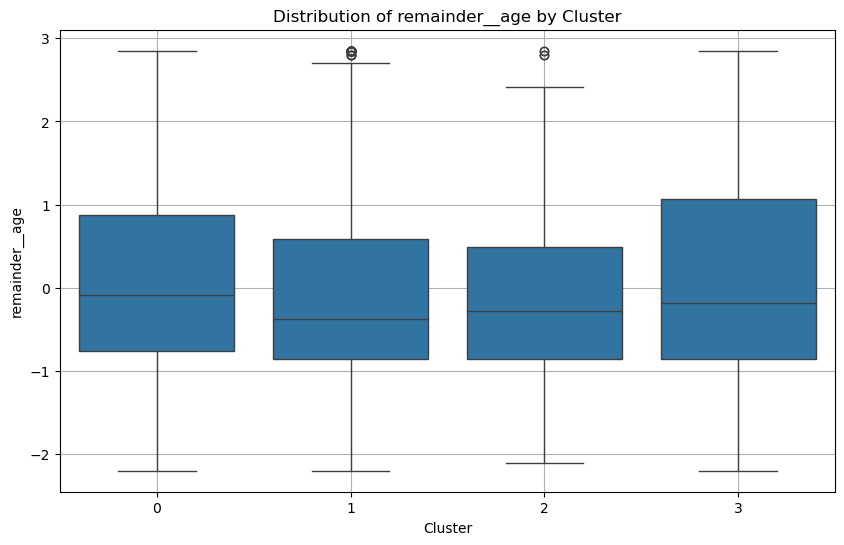

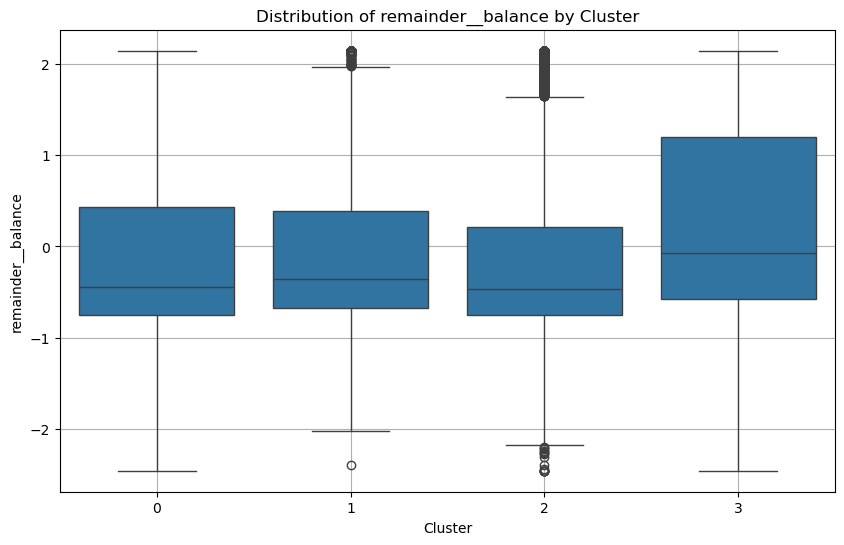

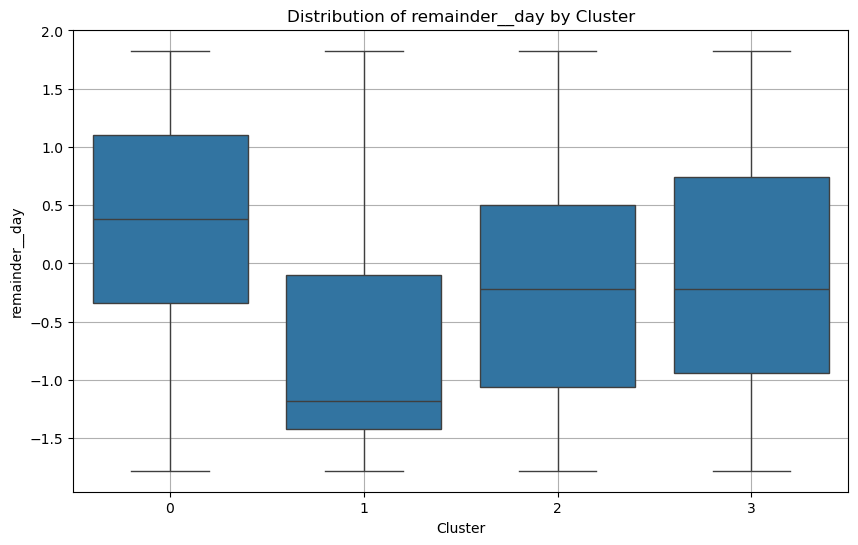

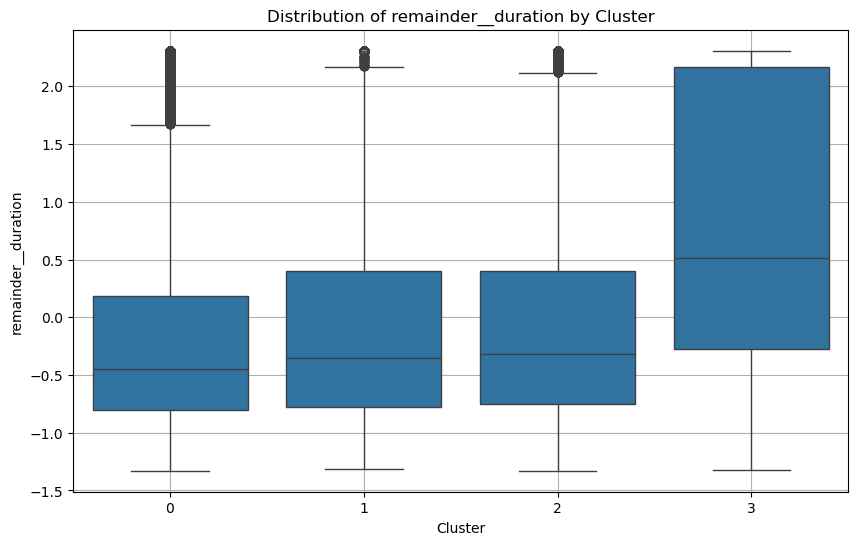

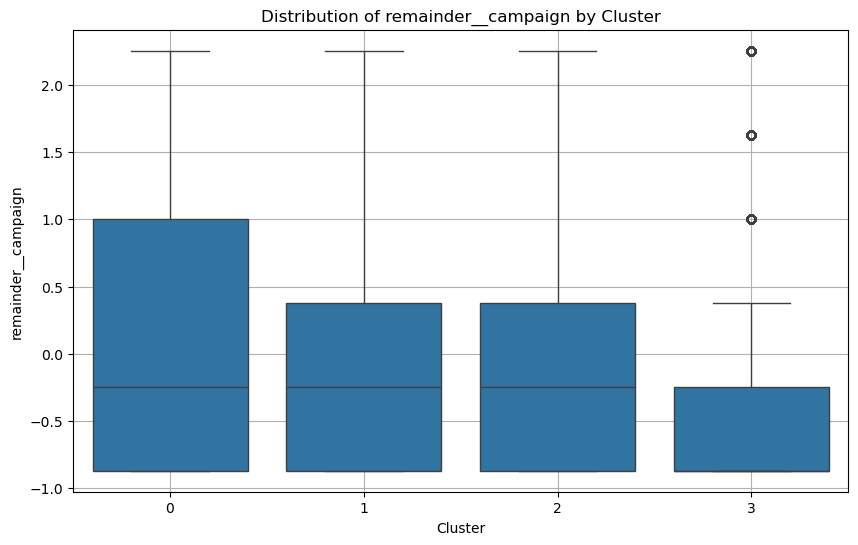

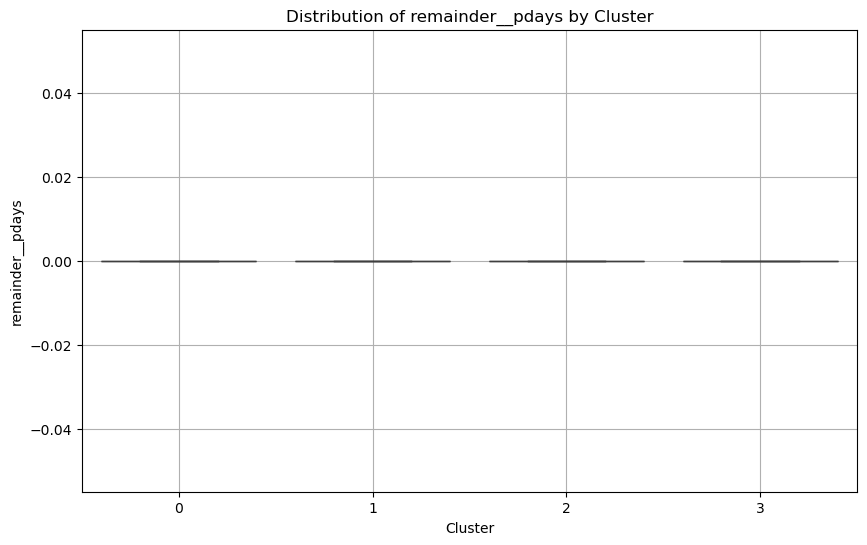

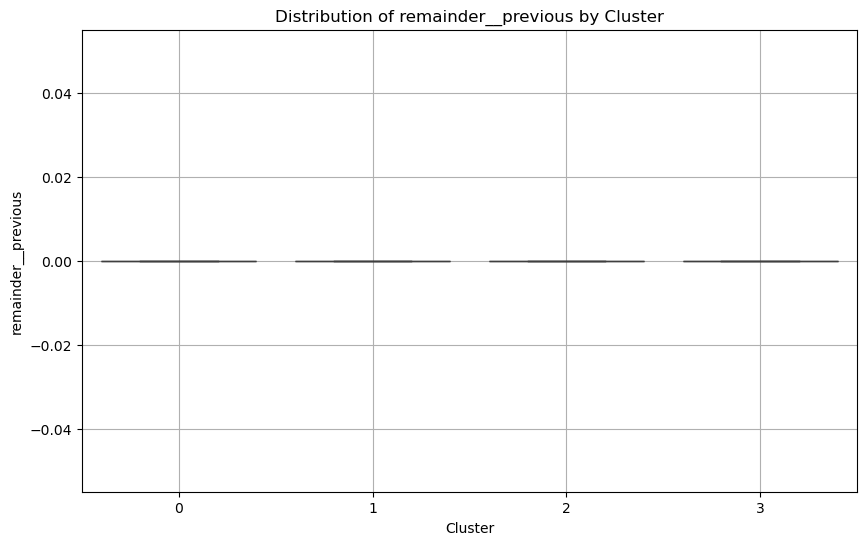

In [8]:
# Step 8: K-Means Clustering
print("\n--- K-Means Clustering ---")
# Determine the optimal number of clusters using the Elbow Method
inertia = []
cluster_range = range(1, 11)  # Test from 1 to 10 clusters
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(encoded_df)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

# Choose the optimal number of clusters based on the elbow plot
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans_final.fit_predict(encoded_df)

# Add the cluster labels to the DataFrame
encoded_df['Cluster'] = cluster_labels

# Evaluate clustering performance with Silhouette Score
silhouette_avg = silhouette_score(encoded_df, cluster_labels)
print(f"\nSilhouette Score for k={optimal_k}: {silhouette_avg:.4f}")

# Visualizing the number of data points in each cluster
plt.figure(figsize=(8, 6))
sns.countplot(x='Cluster', data=encoded_df, palette='viridis')
plt.title(f'Number of Data Points in Each Cluster (k={optimal_k})')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Display cluster centers
print("\n--- Cluster Centers ---")
cluster_centers = pd.DataFrame(kmeans_final.cluster_centers_, columns=encoded_df.columns[:-1])  # Exclude cluster labels
print(cluster_centers)

# Visualizing Characteristics of Each Cluster
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=feature, data=encoded_df)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.grid(True)
    plt.show()